In [1]:
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv("D:\\gitFolders\\python_de_learners_data\\.env")

True

In [26]:
import os
from urllib import request
from PIL import Image

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [8]:
def structure_data(data_input):
    data_prompt = f"""Convert the {data_input} into the most efficient and usable
                python data structures, after analysing it. If mutiple data structures 
                are required, then assign them individually to variables and create them.
                Just provide the final datastructures, don't explain the steps or reasoning"""
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert data analyst skilled at converting raw data to python data structures."},
            {"role": "user", "content": data_prompt}
        ]
    )
    comp_message = completion.choices[0].message.content
    completion_tokens = completion.usage.total_tokens
    # print({"python_ds":comp_message, "token_usage": completion_tokens})
    return {"python_ds":comp_message, "token_usage": completion_tokens}

In [27]:
def gen_png_from_ds(python_ds: str, file_name: str):
    """Uses the give python data structure & returns the Infographic 
    PNG. With the filename given, the infographic is saved to the 
    same location where this notebook is executed."""

    prompt_dalle = f"""Create a minimalistic infographic with {python_ds}, using
    correct chart format for the given data. Use the data provided above only.
    If there are multiple structured data, then for each structured data, 
    create one infographic only."""
    img_resp = client.images.generate(
        model="dall-e-3",
        prompt=prompt_dalle,
        n=1,
        size="1024x1024"
    )
    # save the png file once generated by model
    with request.urlopen(img_resp.data[0].url) as png_resp:
        # this Image is from PIL (pillow library)
        img = Image.open(png_resp)
        img.save(file_name)

    print(f"Image saved to file {file_name}")

    return {"revised_prompt":img_resp.data[0].revised_prompt,
            "image_url": img_resp.data[0].url,
            "file_name": file_name }


In [24]:
prompt_ds = """There are 25 lions, 87 Zebras and Deer 67"""

ext_python_ds = structure_data(prompt_ds) 

print(ext_python_ds)

{'python_ds': '```python\nanimals = {\n    "lions": 25,\n    "zebras": 87,\n    "deer": 67\n}\n\nlions_count = 25\nzebras_count = 87\ndeer_count = 67\n```', 'token_usage': 146}


In [97]:
sentence_to_infog = gen_png_from_ds(ext_python_ds['python_ds'],
                                    "animals_count.png") 

Image saved to file animals_count.png


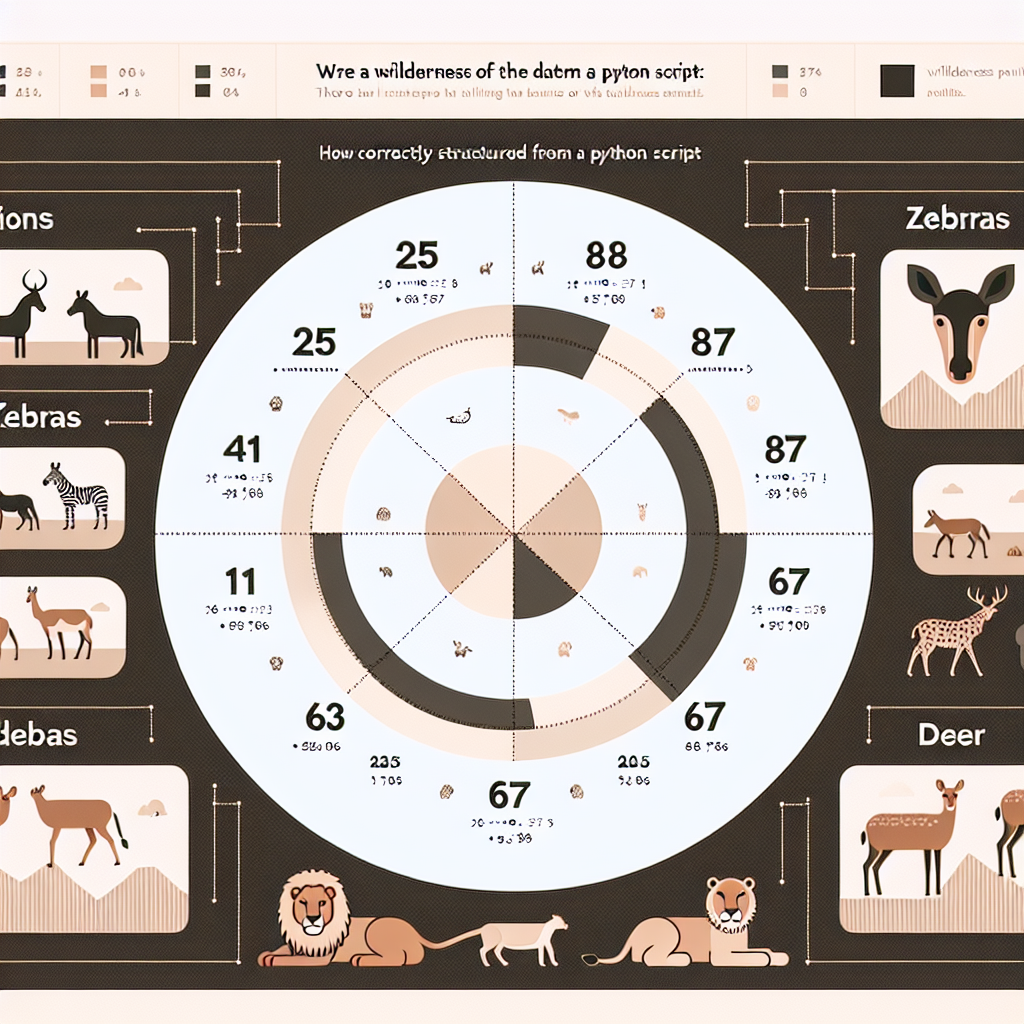

In [98]:
# IPython display 
from IPython import display
display.Image(sentence_to_infog["file_name"])

In [31]:
print(sentence_to_infog['revised_prompt'])

Create a minimalistic infographic representing the count of different animal species, specifically lions, zebras, and deer. The quantities are as follows: lions are 25, zebras are 87, and deer are 67. The infographic should be designed with a suitable chart format that accurately depicts the provided data. There should only be one infographic generated for the given structured data.


In [32]:
notes_prompt = """Remove the bottom ruler from the picture. In the middle of the picture there is 
multiple representation of same animal, keep only the correct one, and remove the other. On top 
the animal names have spelling errors correct them"""

In [80]:
from PIL import Image, ImageDraw

# Create a blank mask image
width, height = 1024, 1024
mask = Image.new("L", (width, height), 0)  # "L" mode for grayscale

# Create a drawing object
draw = ImageDraw.Draw(mask)

In [81]:
# 30, 20 == 994, 60
# 30, 70 == 994, 860
# 30, 860 == 1000, 1015
shape1 = [(60, 800), (960, 960)]  # Top-left and bottom-right coordinates of the circle's bounding box
# shape2 = [(60, 180), (960, 760)]  # Top-left and bottom-right coordinates of the circle's bounding box
# shape3 = [(60, 790), (960, 950)]  # Top-left and bottom-right coordinates of the circle's bounding box
draw.rectangle(shape1, fill=255,) # fill has to be transparent, so alpha is made 0
# draw.rectangle(shape2, fill=255)
# draw.rectangle(shape3, fill=255)
# draw.ellipse(shape, fill=255)  # Fill the circle with white

# Save the mask as a PNG
mask.save("mask.png")

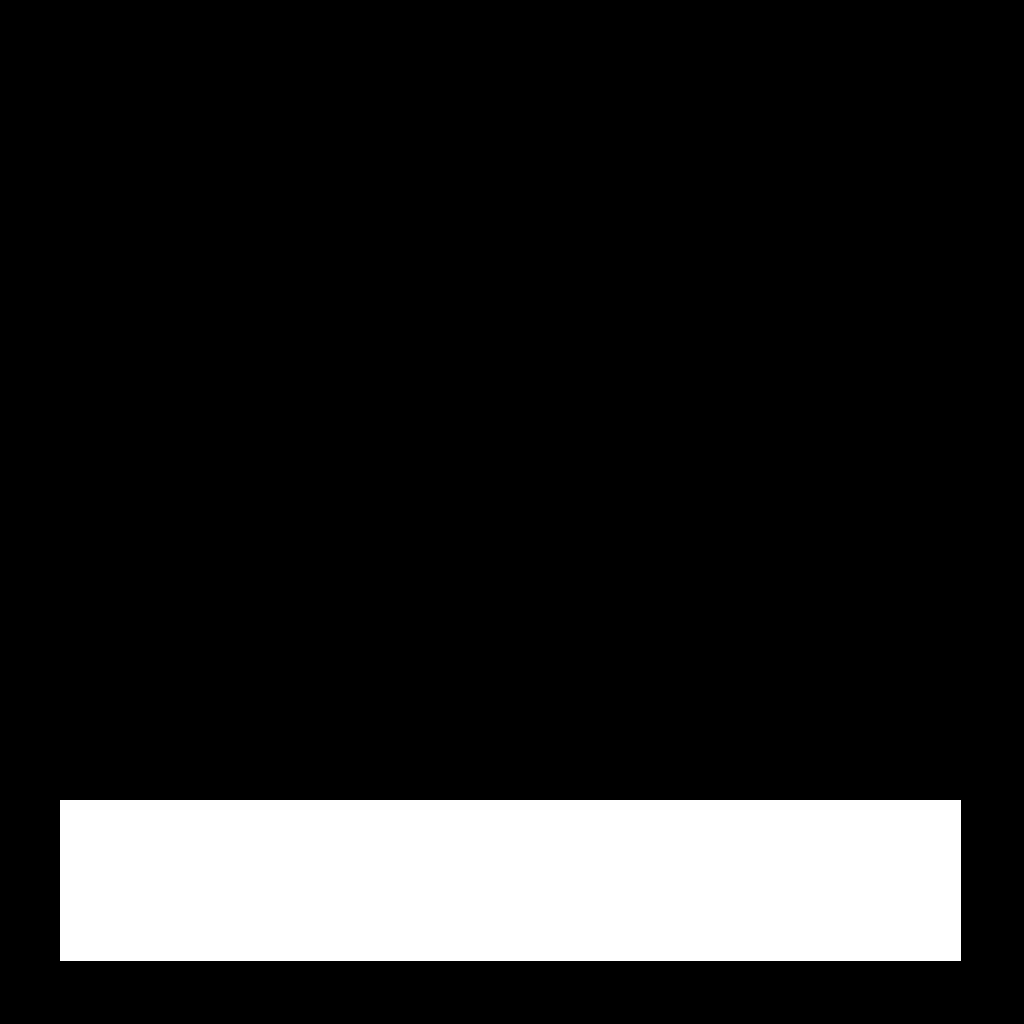

In [82]:
display.Image("mask.png")

In [86]:
def edit_image_withprompt(edit_prompt: str,
                          org_file: str,
                          edited_file: str,
                          mask_file: str = None):
    if mask_file:
        edit_resp = client.images.edit(
            image=open(org_file, "rb"),
            mask=open(mask_file, "rb"),
            prompt=edit_prompt,
            n=1,
            size="1024x1024"
        )
    else:
        edit_resp = client.images.edit(
            image=open(org_file, "rb"),
            prompt=edit_prompt,
            n=1,
            size="1024x1024"
        )
     # save the png file once generated by model
    with request.urlopen(edit_resp.data[0].url) as png_resp:
        # this Image is from PIL (pillow library)
        img = Image.open(png_resp)
        img.save(edited_file)

    print(f"Edited Image saved to file {edited_file}")

    return {"revised_prompt":edit_resp.data[0].revised_prompt,
            "image_url": edit_resp.data[0].url,
            "file_name": edited_file}

### Errors & their resoution procedures:

- Error: "Invalid input image - format must be in ['RGBA', 'LA', 'L'], got RGB.",

- https://stackoverflow.com/questions/74773173/dall-e-api-error-invalid-input-image-format-must-be-in-rgba-la-l
- https://stackoverflow.com/questions/57899997/how-to-create-mask-from-alpha-channel-in-opencv
- https://community.openai.com/t/how-can-i-provide-a-rgba-png-file-to-openai-php-library/22604/3
    - Guys have suggested to use ImageMagik to resolve the issue
        - Installed https://imagemagick.org/archive/binaries/ImageMagick-7.1.1-34-Q16-HDRI-x64-dll.exe

        - Tried to convert:
            magick convert input_rgb_image.png -alpha on -channel A -evaluate set 100% output_rgba_image.png
        - Used the following to verify:
            image_path = "output_rgba_image.png"
            image = Image.open(image_path)
            // Print the image mode to verify
            print("Image mode:", image.mode)  # Should print "RGBA"

A note on Alpha Bending:
- https://www.geeksforgeeks.org/opencv-alpha-blending-and-masking-of-images/

In [89]:
image_path = "animals_count_rgba.png"
image = Image.open(image_path)

# Print the image mode to verify
print("Image mode:", image.mode)  # Should print "RGBA"

Image mode: RGBA


In [90]:
first_edit = edit_image_withprompt(edit_prompt="Remove the ruler and leave it blank",
                                   # mask_file="mask.png",  # No mask file is provided
                                   org_file="animals_count_rgba.png",
                                   edited_file="animal_count_edited.png")

Edited Image saved to file animal_count_edited.png


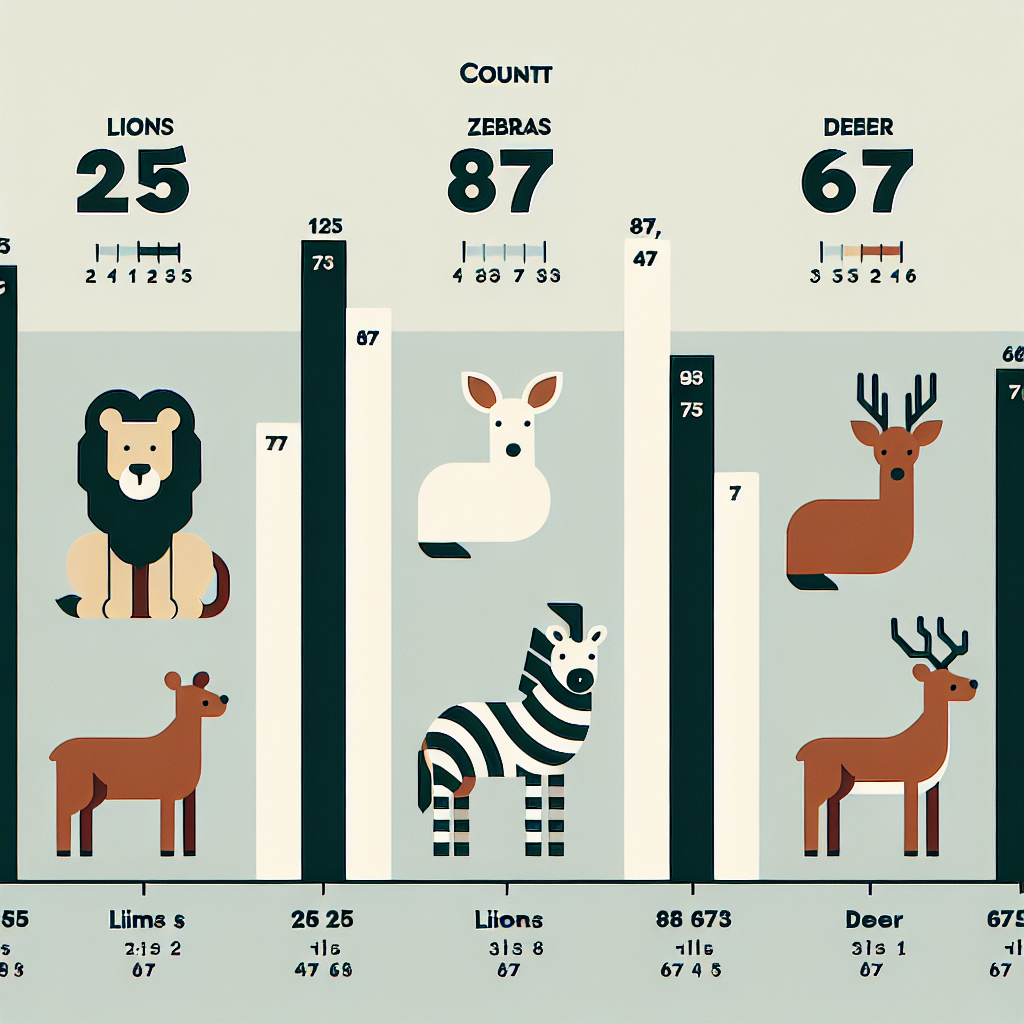

In [91]:
display.Image("animal_count_edited.png")
# without the mask, not much has changed

In [96]:
second_edit = edit_image_withprompt(edit_prompt="Remove the ruler and leave it blank",
                                   mask_file="mask.png",  # No mask file is provided
                                   org_file="animals_count_rgba.png",
                                   edited_file="animal_count_edited_02.png")

Edited Image saved to file animal_count_edited_02.png


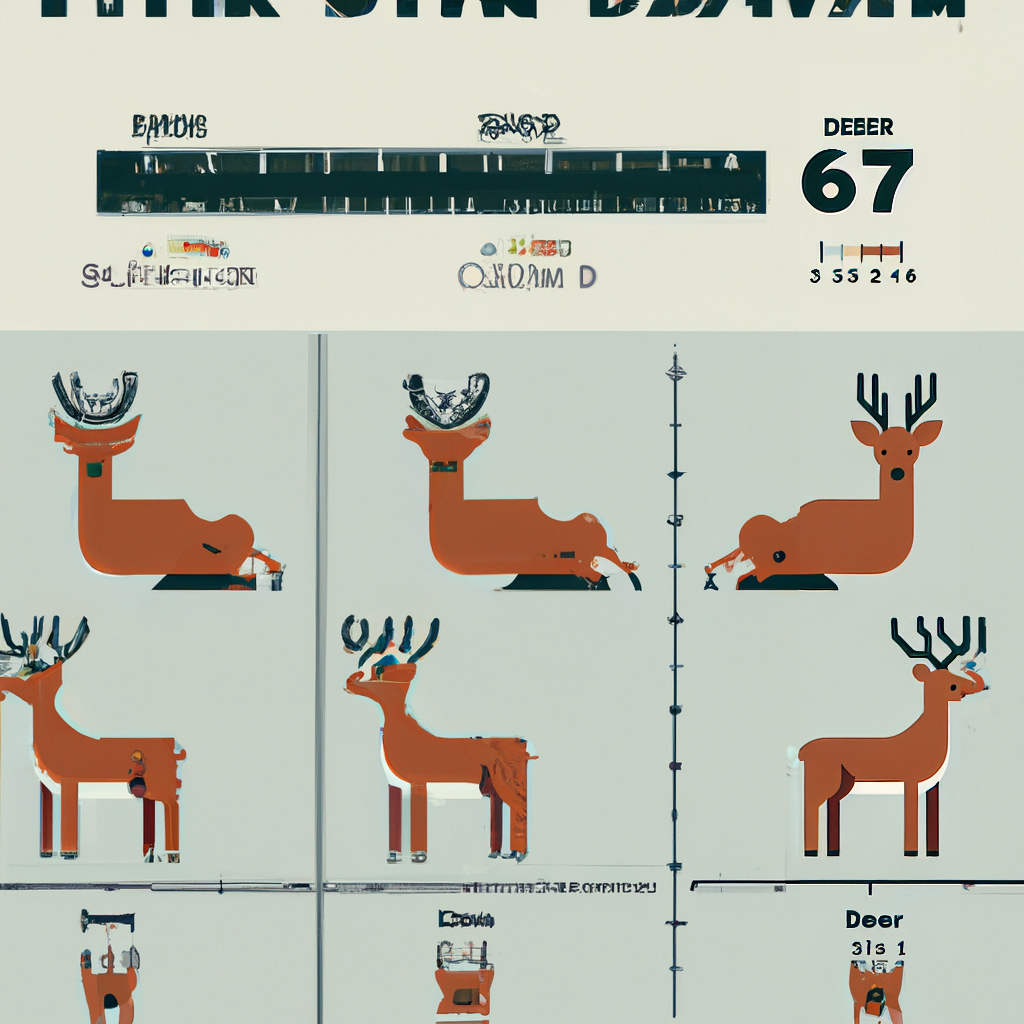

In [99]:
display.Image("animal_count_edited_02.png")
# Not a very good result, but the rulers has been removed